## Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor

## Importing data from kaggle

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 46.5MB/s]


In [5]:
! ls

house-prices-advanced-regression-techniques.zip  kaggle.json  sample_data


In [6]:
! unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Loading data

In [51]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [8]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
df_train.shape

(1460, 81)

In [11]:
df_test.shape

(1459, 80)

In [20]:
df_train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [21]:
df_train.shape

(1460, 81)

Our dataset has 80 features (plus one target feature *SalePrice*) - 38 object features, 35 integer features and 3 float features. Let's perform some EDA! 

## EDA

First, we should take a look on our target feature - *SalePrice*. 

In [25]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Minimum price is above zero, which is good in case of the data quality (price cannot be lower than zero).

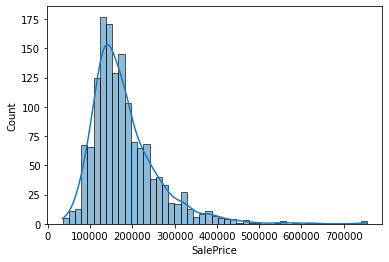

In [26]:
sns.histplot(df_train['SalePrice'], kde = True)

From the plot it can be seen that the prices distribution has positive skewness. Let's see its value.

In [27]:
print('Prices distribution skewness: ', round(df_train['SalePrice'].skew(), 2))

Prices distribution skewness:  1.88


Check missing values in both datasets.

In [28]:
train_miss_values = df_train.isna().sum()
test_miss_values = df_test.isna().sum()

train_miss_values_ratio = round(train_miss_values / len(df_train), 3)*100
test_miss_values_ratio = round(test_miss_values / len(df_test), 3)*100

miss_values = pd.concat([train_miss_values.rename('train set missing values'), train_miss_values_ratio.rename('percent_train'),  test_miss_values.rename('test set missing values'), test_miss_values_ratio.rename('percent_test')], axis=1)
miss_values.loc[~(miss_values==0).all(axis=1)]

,train set missing values,percent_train,test set missing values,percent_test
MSZoning,0,0.0,4.0,0.3
LotFrontage,259,17.7,227.0,15.6
Alley,1369,93.8,1352.0,92.7
Utilities,0,0.0,2.0,0.1
Exterior1st,0,0.0,1.0,0.1
Exterior2nd,0,0.0,1.0,0.1
MasVnrType,8,0.5,16.0,1.1
MasVnrArea,8,0.5,15.0,1.0
BsmtQual,37,2.5,44.0,3.0
BsmtCond,37,2.5,45.0,3.1


Text(0.5, 1.0, 'Heatmap of missing values (TEST)')

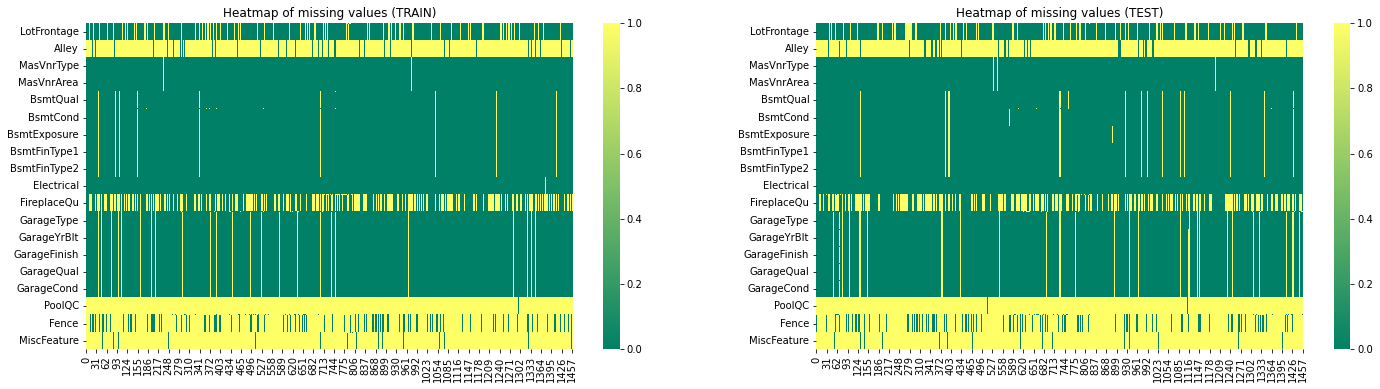

In [29]:
na_cols=df_train.columns[df_train.isna().any()].tolist()
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
sns.heatmap(df_train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values (TRAIN)')

plt.subplot(1,2,2)
sns.heatmap(df_test[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values (TEST)')

In [30]:
print('Percentage of rows with at least one missing value: ', df_train.isna().any(axis=1).sum() / len(df_train) * 100, "%")

Percentage of rows with at least one missing value:  100.0 %


As we can see every row has at least one missing value, but most of these missings come from several features. Let's remove those features (MiscFeature, Fence, PoolQC, FireplaceQu, Alley) and see how it changes. 

In [52]:
df_train_original = df_train.copy()
df_test_original = df_test.copy()

empty_features = ['Id', 'MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley', 'LotFrontage']

df_train = df_train.drop(columns = empty_features)
df_test = df_test.drop(columns = empty_features)

In [53]:
train_miss_values = df_train.isna().sum()
test_miss_values = df_test.isna().sum()

train_miss_values_ratio = round(train_miss_values / len(df_train), 3)*100
test_miss_values_ratio = round(test_miss_values / len(df_test), 3)*100

miss_values = pd.concat([train_miss_values.rename('train set missing values'), train_miss_values_ratio.rename('percent_train'),  test_miss_values.rename('test set missing values'), test_miss_values_ratio.rename('percent_test')], axis=1)
miss_values.loc[~(miss_values==0).all(axis=1)]

,train set missing values,percent_train,test set missing values,percent_test
MSZoning,0,0.0,4.0,0.3
Utilities,0,0.0,2.0,0.1
Exterior1st,0,0.0,1.0,0.1
Exterior2nd,0,0.0,1.0,0.1
MasVnrType,8,0.5,16.0,1.1
MasVnrArea,8,0.5,15.0,1.0
BsmtQual,37,2.5,44.0,3.0
BsmtCond,37,2.5,45.0,3.1
BsmtExposure,38,2.6,44.0,3.0
BsmtFinType1,37,2.5,42.0,2.9


Text(0.5, 1.0, 'Heatmap of missing values (TEST)')

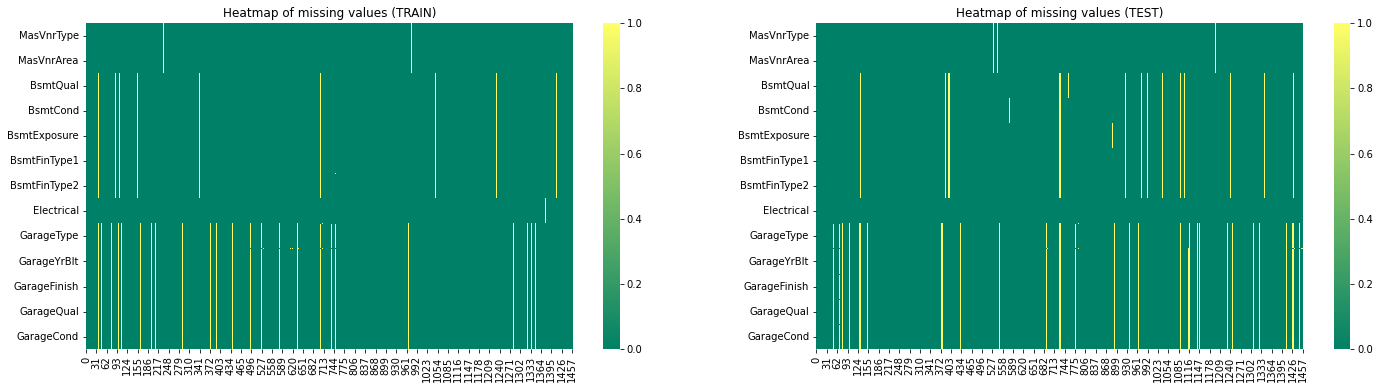

In [54]:
na_cols=df_train.columns[df_train.isna().any()].tolist()
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
sns.heatmap(df_train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values (TRAIN)')

plt.subplot(1,2,2)
sns.heatmap(df_test[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values (TEST)')

In [55]:
print('Percentage of rows with at least one missing value (after removing almost empty features): ', df_train.isna().any(axis=1).sum() / len(df_train) * 100, "%")

Percentage of rows with at least one missing value (after removing almost empty features):  8.356164383561644 %


It looks much better now! But still we have more or less 8% of rows with at least one missing value. It's too much to just remove those rows, so we will try to handle it later. 

In [56]:
print(f'Duplicates in train set: {df_train.duplicated().sum()} ({np.round(100*df_train.duplicated().sum()/len(df_train),1)}%)')
print(f'Duplicates in test set: {df_test.duplicated().sum()} ({np.round(100*df_test.duplicated().sum()/len(df_test),1)}%)')

Duplicates in train set: 0 (0.0%)
Duplicates in test set: 0 (0.0%)


Zero duplitaces - that's great. 

In [57]:
float_features = [f for f in df_train.columns if (df_train[f].dtype == float)]

In [60]:
int_features = [f for f in df_train.columns if (df_train[f].dtype == int)]

In [61]:
object_features = [f for f in df_train.columns if (df_train[f].dtype == object)]

In [62]:
print('Float features: ', len(float_features))
print('Integer features: ', len(int_features))
print('Object features: ', len(object_features))
print(df_train.dtypes.value_counts())

Float features:  2
Integer features:  34
Object features:  38
object     38
int64      34
float64     2
dtype: int64


In [ ]:
for feature in float_features:
    plt.figure(figsize=(30,4))
    plt.subplot(1,2,1)
    #plt.ylim([0,1500])
    #plt.xlim([0,10000])
    if df_train[feature].nunique() > 30:
      sns.histplot(data=df_train, x=feature)
    else:
      sns.countplot(data=df_train, x=feature)
    plt.title(feature+' (TRAIN)')

    if feature in df_test.columns:
      plt.subplot(1,2,2)
      #plt.ylim([0,1500])
      #plt.xlim([0,10000])
      if df_test[feature].nunique() > 30:
        sns.histplot(data=df_test, x=feature)
      else:
        sns.countplot(data=df_test, x=feature)
      plt.title(feature+' (TEST)')

    plt.show()

In [ ]:
for feature in object_features:
    plt.figure(figsize=(30,4))
    plt.subplot(1,2,1)
    #plt.ylim([0,1500])
    #plt.xlim([0,10000])
    if df_train[feature].nunique() > 30:
      sns.histplot(data=df_train, x=feature)
    else:
      sns.countplot(data=df_train, x=feature, order = df_train[feature].value_counts().index)
    plt.title(feature+' (TRAIN)')

    if feature in df_test.columns:
      plt.subplot(1,2,2)
      #plt.ylim([0,1500])
      #plt.xlim([0,10000])
      if df_test[feature].nunique() > 30:
        sns.histplot(data=df_test, x=feature)
      else:
        sns.countplot(data=df_test, x=feature, order = df_test[feature].value_counts().index)
      plt.title(feature+' (TEST)')

    plt.show()

In [ ]:
for feature in int_features:
    plt.figure(figsize=(30,4))
    plt.subplot(1,2,1)
    #plt.ylim([0,1500])
    #plt.xlim([0,10000])
    if df_train[feature].nunique() > 30:
      sns.histplot(data=df_train, x=feature)
    else:
      sns.countplot(data=df_train, x=feature)
    plt.title(feature+' (TRAIN)')

    if feature in df_test.columns:
      plt.subplot(1,2,2)
      #plt.ylim([0,1500])
      #plt.xlim([0,10000])
      if df_test[feature].nunique() > 30:
        sns.histplot(data=df_test, x=feature)
      else:
        sns.countplot(data=df_test, x=feature)
      plt.title(feature+' (TEST)')

    plt.show()

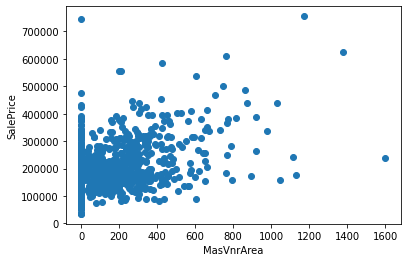

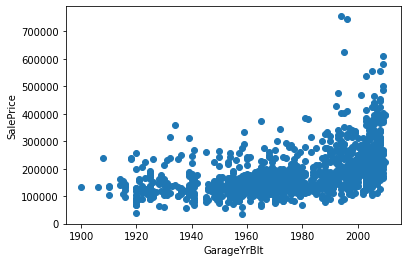

In [70]:
for feature in float_features:
    plt.figure()
    plt.scatter(df_train[feature], df_train['SalePrice'])
    plt.xlabel(feature)
    plt.ylabel('SalePrice')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


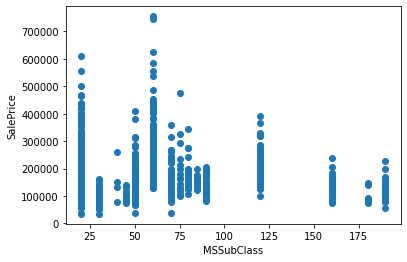

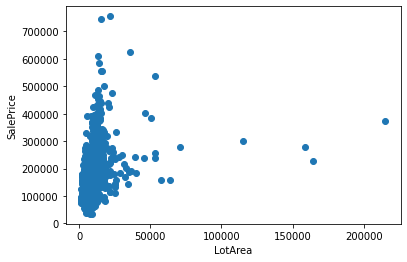

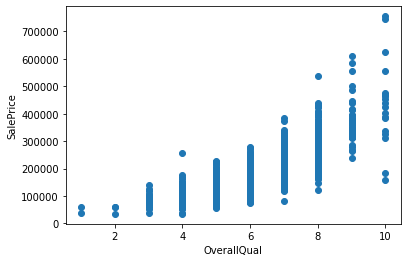

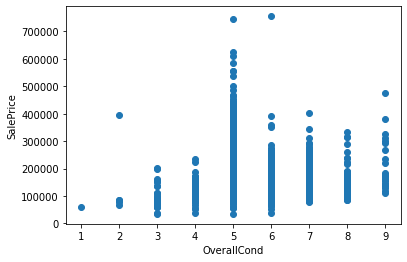

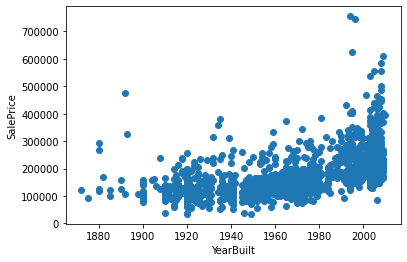

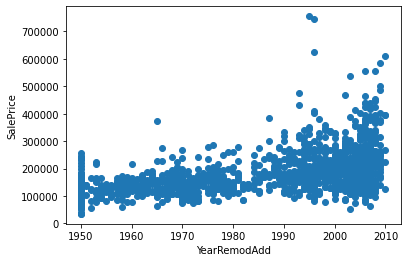

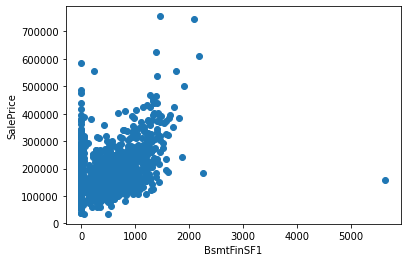

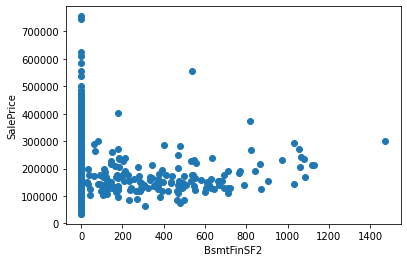

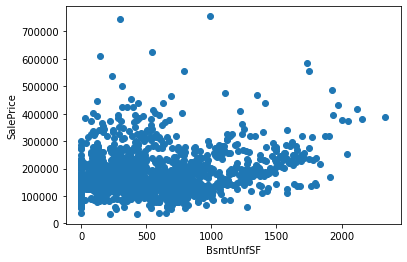

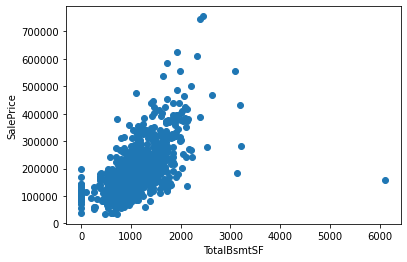

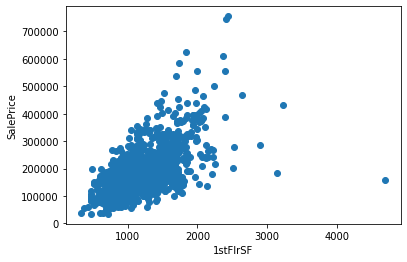

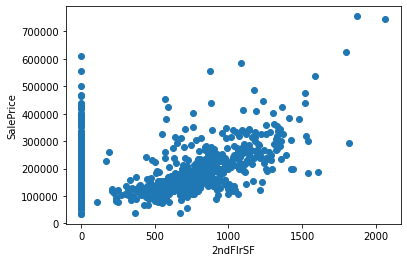

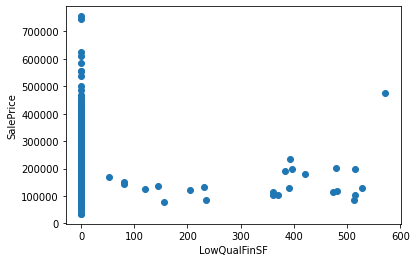

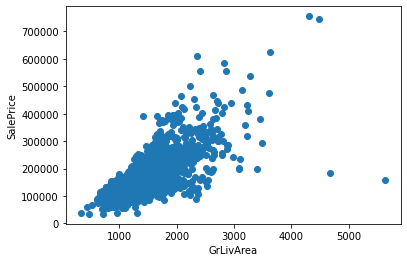

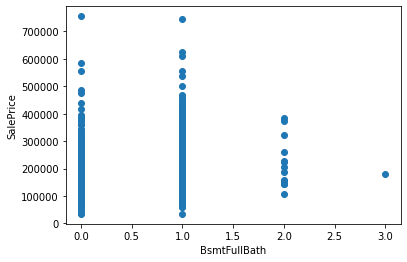

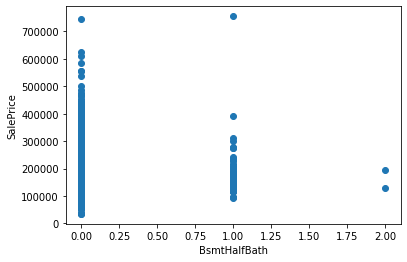

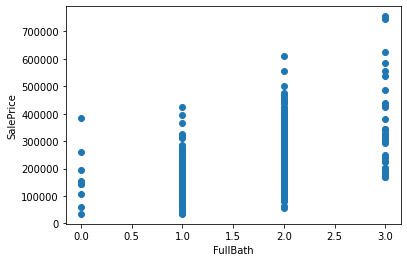

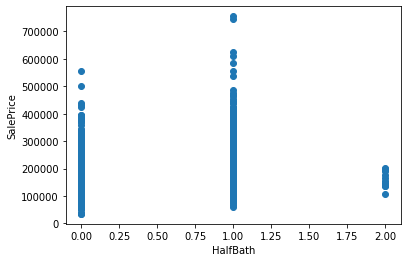

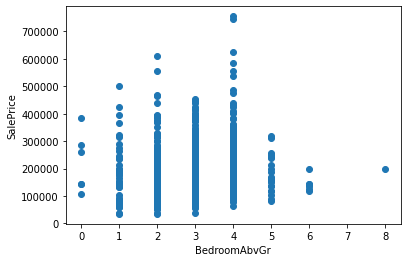

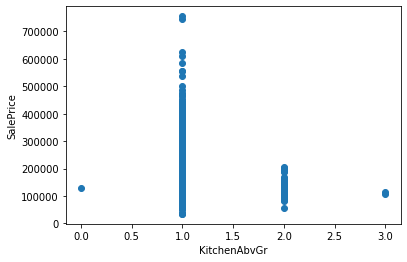

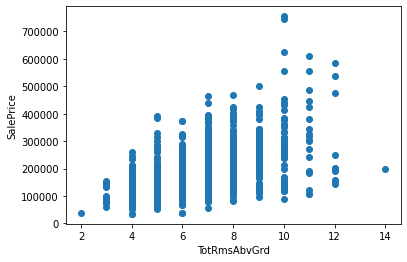

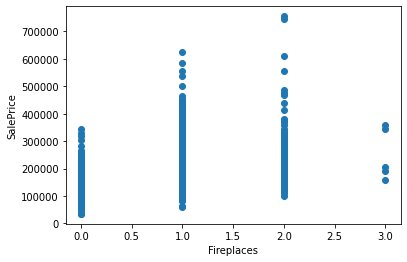

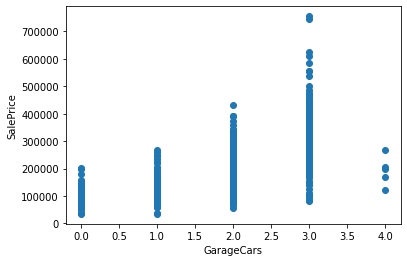

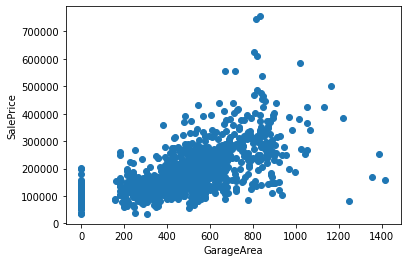

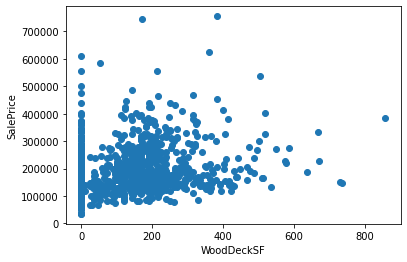

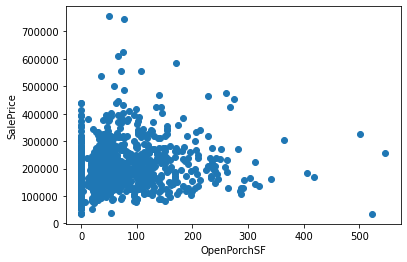

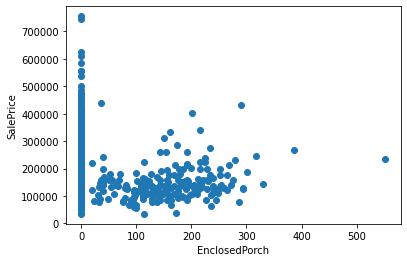

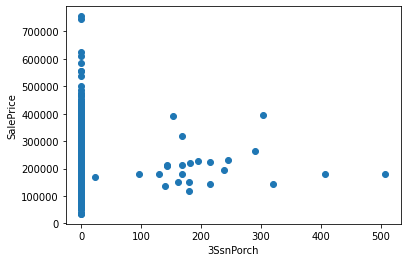

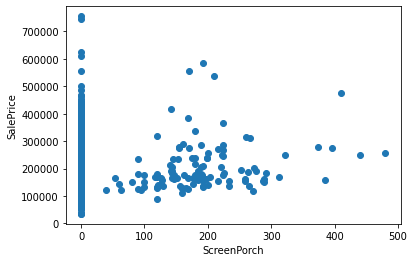

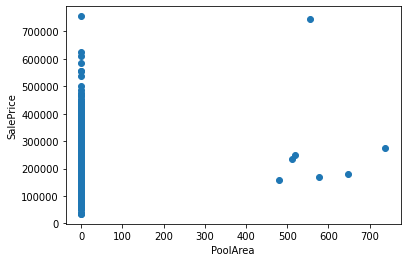

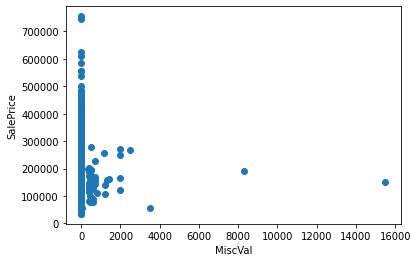

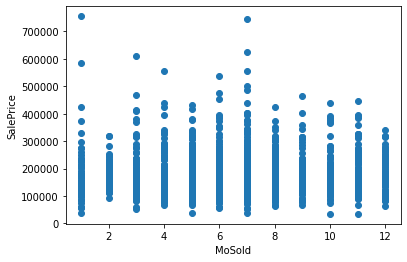

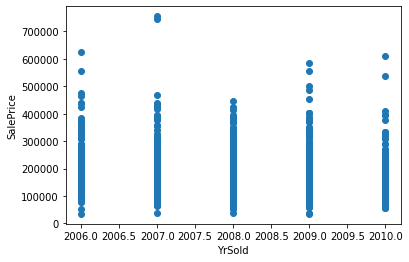

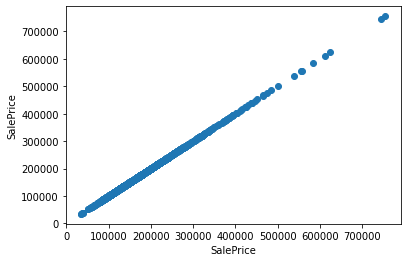

In [75]:
for feature in int_features:
    plt.figure()
    plt.scatter(df_train[feature], df_train['SalePrice'])
    plt.xlabel(feature)
    plt.ylabel('SalePrice')

Lets try to remove highly correlated features (features with high correlation may not be independent and independence of all features is one the models assumptions). 

### Feature engineering

Let's create some new features. 

In [79]:
df_train['haspool'] = df_train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_train['totalarea'] = df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train['totalbathrooms'] = df_train['FullBath'] + df_train['HalfBath']
df_train['hasgarage'] = df_train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_train['hasbsmt'] = df_train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_train['hasfireplace'] = df_train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

df_test['haspool'] = df_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_test['totalarea'] = df_test['BsmtFinSF1'] + df_test['BsmtFinSF2'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test['totalbathrooms'] = df_test['FullBath'] + df_test['HalfBath']
df_test['hasgarage'] = df_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_test['hasbsmt'] = df_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_test['hasfireplace'] = df_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

And plot correlation matrix to see correlation between features and the target. 

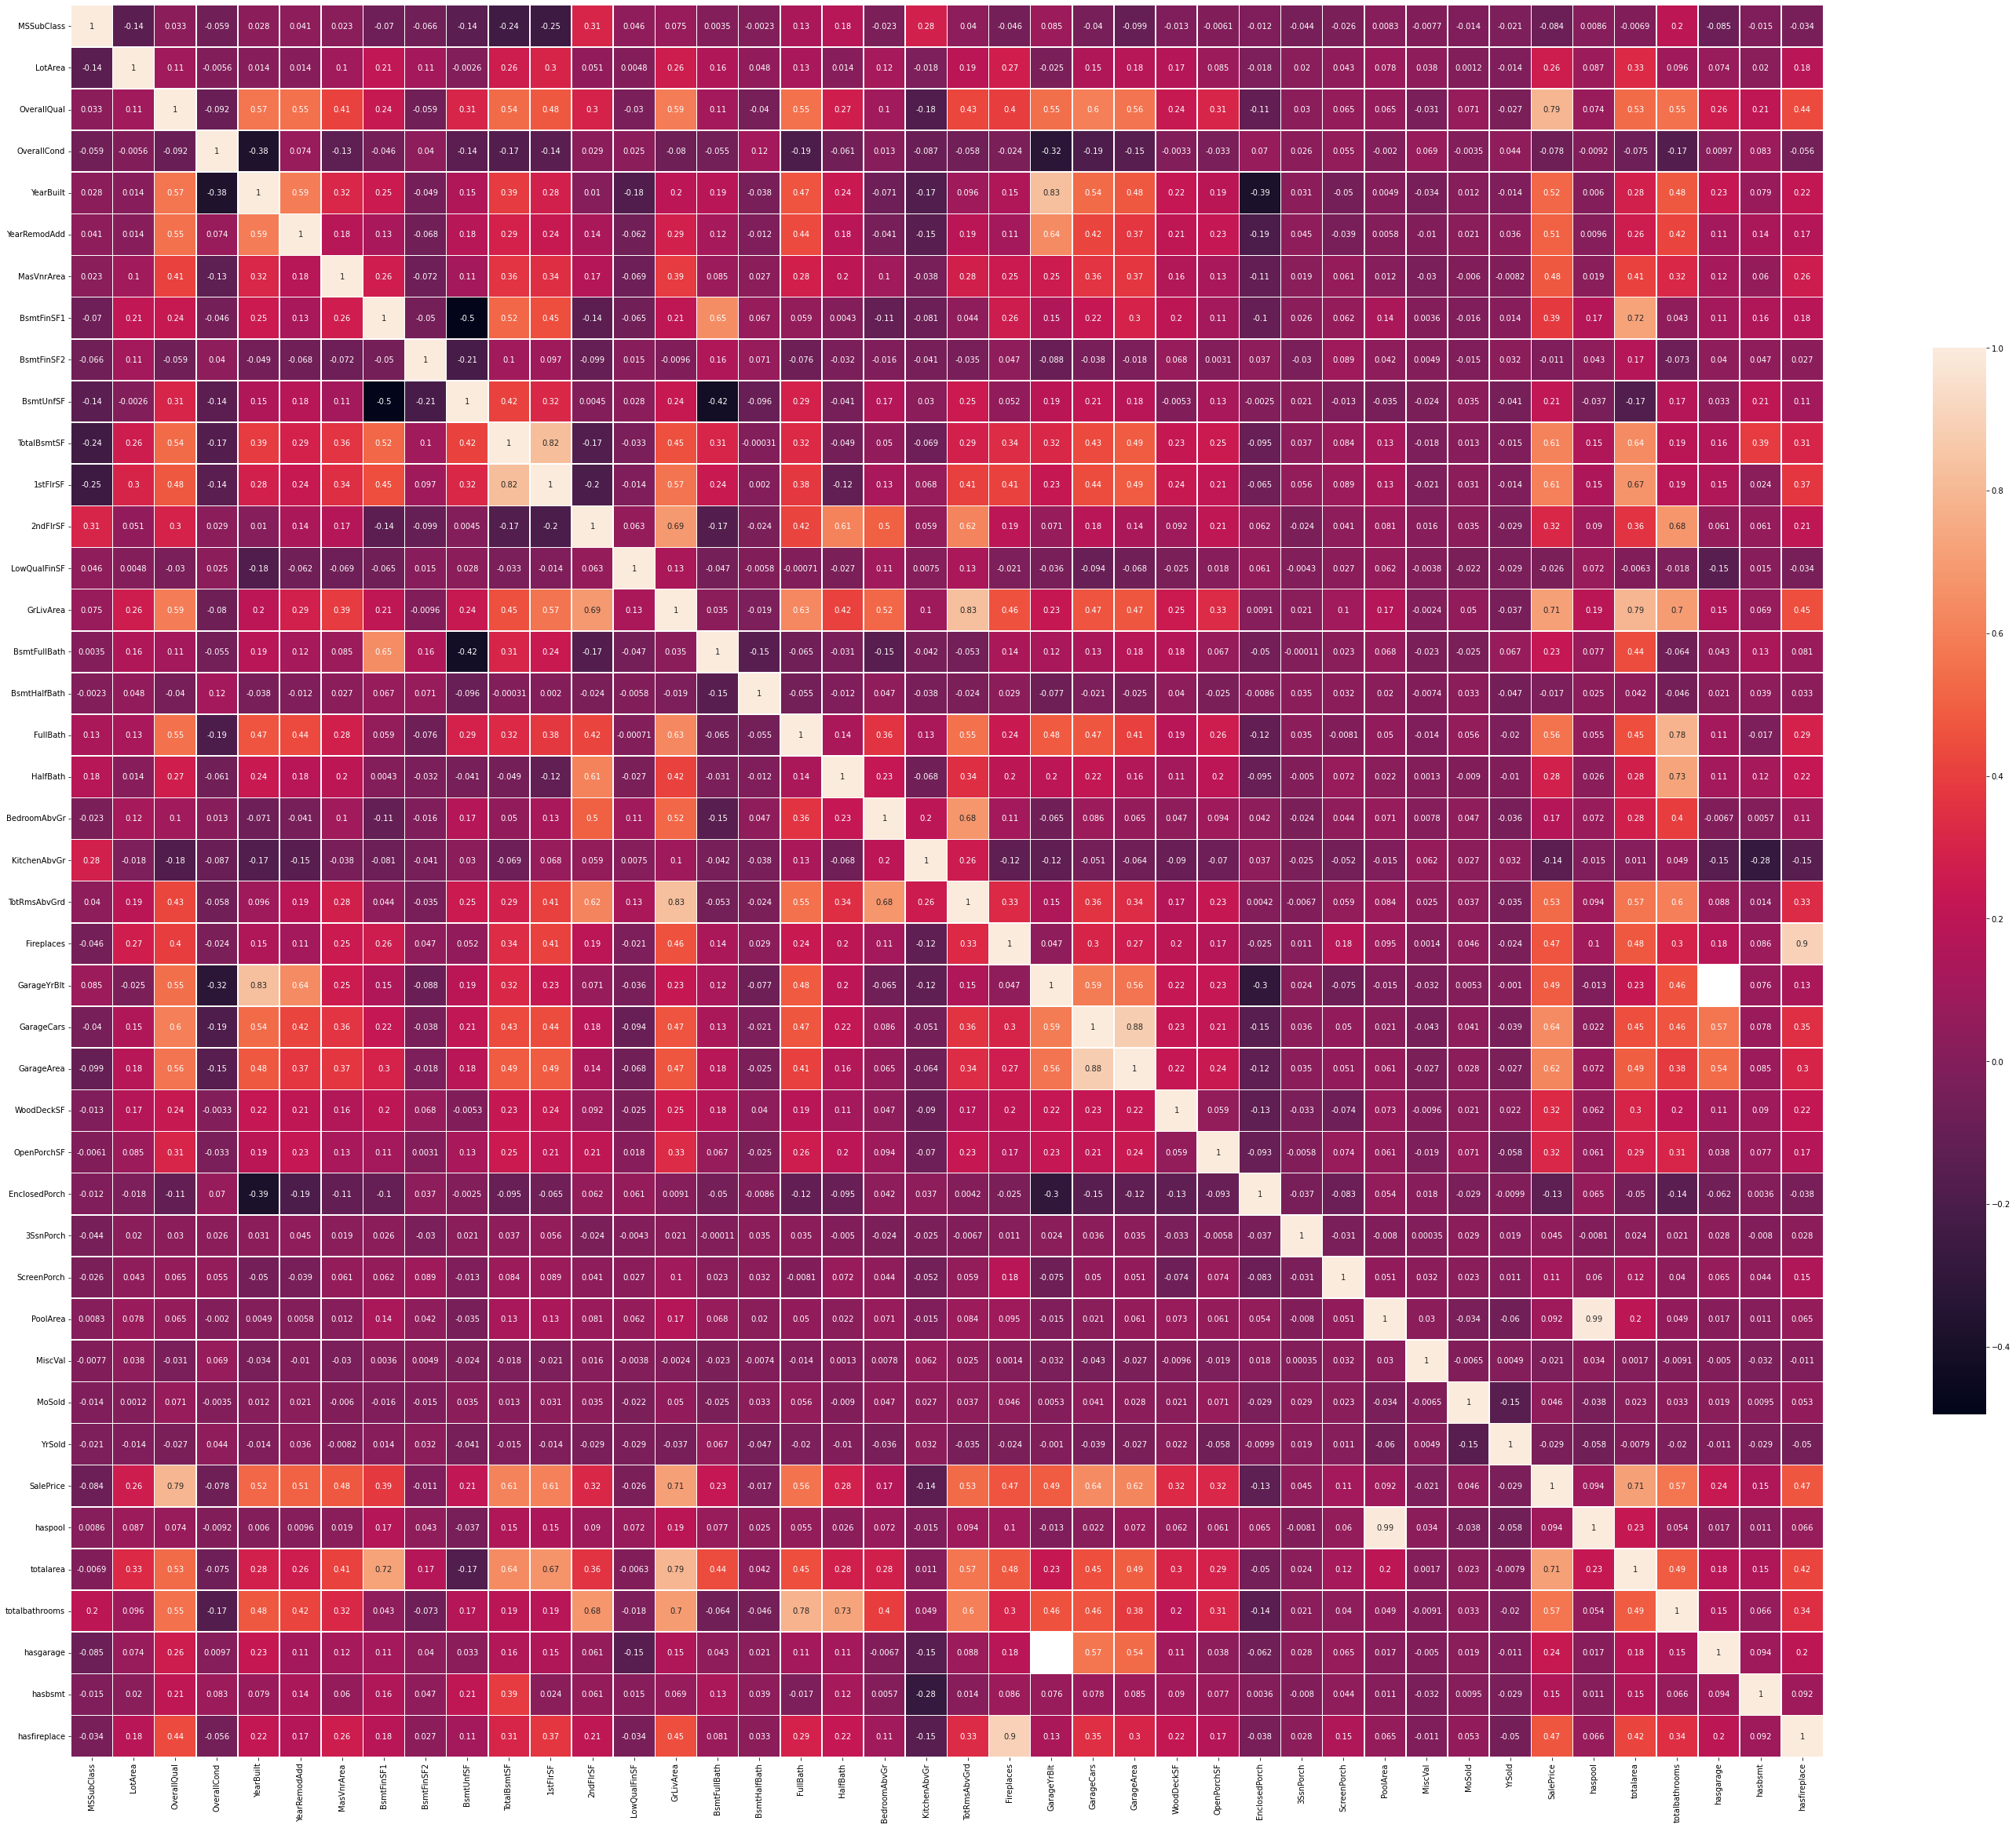

In [80]:
plt.figure(figsize=(50,50))
train_corr = df_train.copy()
train_corr = train_corr.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_corr, square=True, annot = True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Some features has really high correlation with other features. It's good idea to remove highly correlated features. 

In [81]:
train_corr = df_train.drop(columns = ['SalePrice']).copy()
train_corr = train_corr.corr().abs()
upper_tri = train_corr.where(np.triu(np.ones(train_corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
to_drop 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


['1stFlrSF',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageArea',
 'haspool',
 'hasfireplace']

In [82]:
df_train.dtypes.value_counts()

int64      40
object     38
float64     2
dtype: int64

In [83]:
train = df_train.copy()
test = df_test.copy()

features = pd.concat([train, test]).reset_index(drop=True)

In [84]:
to_drop = ['1stFlrSF',
           'TotRmsAbvGrd',
           'GarageYrBlt',
           'GarageArea',
           'PoolArea',
           'Fireplaces',
           'SalePrice']

In [85]:
features = features.drop(columns = to_drop)

In [86]:
features.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold',
       'YrSold', 'SaleTyp

In [87]:
features.shape

(2919, 73)

In [88]:
features.dtypes.value_counts()

object     38
int64      26
float64     9
dtype: int64

In [89]:
nan_values = features.isna().sum()
nan_values.loc[~(nan_values==0)]

MSZoning          4
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
MasVnrArea       23
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinSF1        1
BsmtFinType2     80
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType      157
GarageFinish    159
GarageCars        1
GarageQual      159
GarageCond      159
SaleType          1
totalarea         1
dtype: int64

We still have a lot of features with missing values. Let's impute missing values with median for numeric features and mode for categorical ones. 

In [90]:
for feature in features.columns:
  if features[feature].dtype == float or features[feature].dtype == int:
    features[feature] = features[feature].fillna(features[feature].median())

  if features[feature].dtype == object:
    features[feature] = features[feature].fillna(features[feature].mode()[0])

In [91]:
nan_values = features.isna().sum()
nan_values.loc[~(nan_values==0)]

Series([], dtype: int64)

Problem of missing values solved.

Let's transform categorical features with get_dummies() function. 

In [92]:
features_final = pd.get_dummies(features).reset_index(drop = True)

In [93]:
print(features_final.shape)

(2919, 269)


Split dataset to original train and test sets. 

In [101]:
train = features_final.iloc[:df_train.shape[0]]
test = features_final.iloc[df_train.shape[0]:]

In [102]:
print(train.shape)
print(test.shape)

(1460, 269)
(1459, 269)


In [103]:
train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [104]:
test.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,20,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,0,0,0,1,0,0,0,0,1,0
1461,20,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,0,0,0,1,0,0,0,0,1,0
1462,60,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,0,0,0,1,0,0,0,0,1,0
1463,60,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,...,0,0,0,1,0,0,0,0,1,0
1464,120,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,...,0,0,0,1,0,0,0,0,1,0


In [105]:
target = df_train['SalePrice']

### XGBOOST MODEL

Now it's time to train a regression model. The choice fell on the XGBoost regression model, as it usually perform better than linear models like Lasso, Ridge or ElasticNet. 

In [106]:
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size = 0.3, shuffle=True, random_state = 42)

In [107]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1022, 269)
(438, 269)
(1022,)
(438,)


Let's use GirdSearchCV to find the best parameters for the XGBRegressor model.

In [108]:
parameters = {'objective':['reg:linear'],
              'learning_rate': [0.008, 0.01, 0.012],
              'max_depth': [3, 4, 5],
              'eval_metric': ['rmse'],
              'n_estimators': [500, 1000, 1500]}

In [109]:
xgb = XGBRegressor()

In [110]:
xgb_grid = GridSearchCV(xgb, parameters, cv = 5)

In [111]:
xgb_grid.fit(x_train, y_train)

[12:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'eval_metric': ['rmse'],
                         'learning_rate': [0.008, 0.01, 0.012],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [500, 1000, 1500],
                         'objective': ['reg:linear']})

And the best parameters are...

In [112]:
xgb_grid.best_params_

{'eval_metric': 'rmse',
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 1000,
 'objective': 'reg:linear'}

Let's define new model with the best parameters found and then try to predict SalePrice values for the kaggle submission file.

In [113]:
xgb_best = xgb_grid.best_estimator_

In [115]:
def rmse(model, x, y):
  rmse = mean_squared_error(model.predict(x), y, squared = False)
  return rmse

In [116]:
print(rmse(xgb_best, x_test, y_test))

26418.178643167128


In [120]:
pred = xgb_best.predict(test)

In [121]:
sub = pd.read_csv('sample_submission.csv')

In [122]:
sub['SalePrice'] = pred

In [123]:
sub

,Id,SalePrice
0,1461,121372.062500
1,1462,167170.671875
2,1463,183420.734375
3,1464,191408.218750
4,1465,210913.781250
...,...,...
1454,2915,85758.804688
1455,2916,91676.164062
1456,2917,176937.296875
1457,2918,127021.710938


In [77]:
sub.to_csv('submission.csv', index = False)